# 1 Import Library

In [9]:
%reset -f

In [10]:
import os
import math
pwd = os.getcwd()
%env DATAPATH={pwd}/wrk/

env: DATAPATH=/home/test01/App/01_PySeis/xu/TASK6_PASS_Marine/numerical_modeling/wrk/


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, interpolate
import sys
sys.path.append("../")
import plotting
from pyseis.wave_equations import elastic_isotropic
from pyseis.wave_equations import acoustic_isotropic
from pyseis.wavelets.elastic import Elastic2D
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion
%matplotlib inline

# 2 Read Model

In [12]:
dir_model = "./model/"
dir_seis  = "./seis/"
ox=0.0; oz=0.0
ex=2000.0; ez=2501
dx=2.0; dz=2.0
npadx,npadz = 100,100
nx=len(np.arange(ox,ex,dx)); nz=len(np.arange(oz,ez,dz))
model_origins = (ox, oz)
model_sampling = (dx, dz)

model_padding = (npadx,npadz)
### Read (dx, dz) = (2, 2) model
vp2d_base_true = np.fromfile(dir_model+"res_FC05_vp2m_base_true_Gradient.bin", dtype="float32")
vp2d_base_init = np.fromfile(dir_model+"res_FC05_vp2m_base_init_Gradient.bin", dtype="float32")

vp2d_moni_true = np.fromfile(dir_model+"res_FC05_vp2m_moni_true_Gradient.bin", dtype="float32")
vp2d_moni_init = np.fromfile(dir_model+"res_FC05_vp2m_moni_init_Gradient.bin", dtype="float32")

vp2d_base_true = vp2d_base_true.reshape(nx,nz)
vp2d_base_init = vp2d_base_init.reshape(nx,nz)
vp2d_moni_true = vp2d_moni_true.reshape(nx,nz)
vp2d_moni_init = vp2d_moni_init.reshape(nx,nz)

In [13]:


print(vp2d_base_true.shape, vp2d_moni_true.shape)

(1000, 1251) (1000, 1251)


# 3 Source and Receiver Location

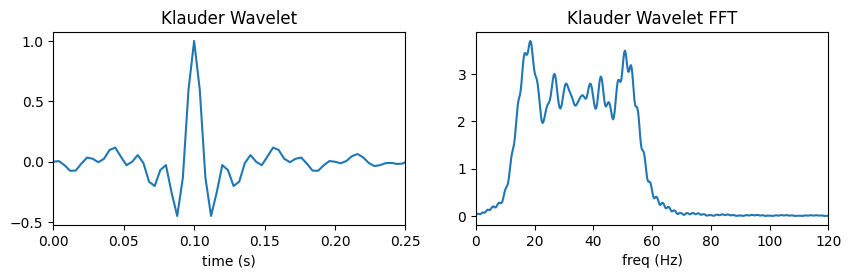

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def generate_klauder_wavelet(nt, dt, f1, f2, T, delay, taper_ratio=0.0):
    """
    Generate a Klauder wavelet by autocorrelating a linear FM (chirp) signal.
    - nt: number of samples in output wavelet
    - dt: sample interval (s)
    - f1, f2: start/end frequencies of the chirp (Hz)
    - T: chirp duration (s) used to build the wavelet
    - delay: time (s) at which the Klauder wavelet's main lobe peak will be centered in the output
    - taper_ratio: 0..1 cosine taper fraction applied to chirp ends (0 = none)
    """
    # --- build LFM chirp (source) ---
    nT = max(2, int(np.round(T / dt)))
    t_chirp = np.arange(nT) * dt
    k = (f2 - f1) / T if T > 0 else 0.0  # sweep rate (Hz/s)
    phase = 2.0 * np.pi * (f1 * t_chirp + 0.5 * k * t_chirp**2)
    s = np.cos(phase)

    # optional cosine taper to reduce sidelobes (keeps classic shape even if 0)
    if taper_ratio > 0.0:
        m = len(s)
        nedge = int(np.clip(np.floor(0.5 * taper_ratio * m), 0, m // 2))
        if nedge > 0:
            w = np.ones(m)
            # half-cosine ramps
            n = np.arange(nedge)
            w[:nedge] = 0.5 * (1 - np.cos(np.pi * (n + 1) / (nedge + 1)))
            w[-nedge:] = w[:nedge][::-1]
            s *= w

    # --- autocorrelation to get Klauder wavelet ---
    # scale by dt so energy is consistent with continuous-time integral
    ac = np.correlate(s, s, mode='full') * dt
    ac /= np.max(np.abs(ac))  # normalize peak to 1.0
    mid = len(s) - 1  # zero lag index in ac

    # --- place autocorrelation into output buffer, centered at 'delay' ---
    out = np.zeros(nt, dtype=float)
    i_delay = int(np.round(delay / dt))  # where the peak will appear
    for m in range(len(ac)):
        j = i_delay + (m - mid)
        if 0 <= j < nt:
            out[j] = ac[m]

    return out

def plot_wavelet(wavelet, d_t, title='wavelet', figsize=(10, 2.5), xlim_time=None, xlim_freq=None):
    wavelet_fft = np.fft.rfft(wavelet)
    freqs = np.fft.rfftfreq(len(wavelet), d_t)
    t = d_t * np.arange(len(wavelet))

    fig, axs = plt.subplots(1, 2, figsize=figsize)

    axs[0].plot(t, wavelet)
    axs[0].set_xlabel('time (s)')
    axs[0].set_title(title)
    if xlim_time is not None:
        axs[0].set_xlim(xlim_time)

    axs[1].plot(freqs, np.abs(wavelet_fft))
    axs[1].set_xlabel('freq (Hz)')
    axs[1].set_title(f'{title} FFT')
    if xlim_freq is not None:
        axs[1].set_xlim(xlim_freq)

    plt.show()

# ---------------------------
# Parameters (example)
# ---------------------------
nt = 1000
dt = 0.004          # 4 ms
delay = 0.1         # peak at 0.1 s in the output
f1, f2 = 10, 60     # sweep band for the chirp (Hz)
T = 0.5             # chirp duration used to form the wavelet (s)
taper_ratio = 0.0   # 0..1, optional cosine end-taper on chirp

# Generate and plot
klauder = generate_klauder_wavelet(nt, dt, f1, f2, T, delay, taper_ratio)
plot_wavelet(klauder, dt, title='Klauder Wavelet', xlim_time=(0, 0.25), xlim_freq=(0, 120))


## Test 1 source depth 10m

In [15]:
### Define Source (3) and Receiver (212) 

# Receiver spacing and seafloor depth
drec = 10.0
recx1 = 500.0   # start position (x = 100 m)
recx2 = 1500.0  # end position (x = 2220 m)
recz = np.ones(int((recx2 - recx1) / drec)) * 100.0  # constant depth of 100 m

# Receiver x-coordinates along the seafloor
recx = np.arange(recx1, recx2, drec)

# Combine receivers into [x, z]
recs = np.column_stack((recx, recz))

# Manually specify source positions
srcx = np.array([450.0, 900.0, 1750.0])  # chosen x positions (m)
srcz = np.array([10.0, 10.0, 10.0])       # all sources at 10 m depth

# Combine sources into [x, z]
srcs = np.column_stack((srcx, srcz))


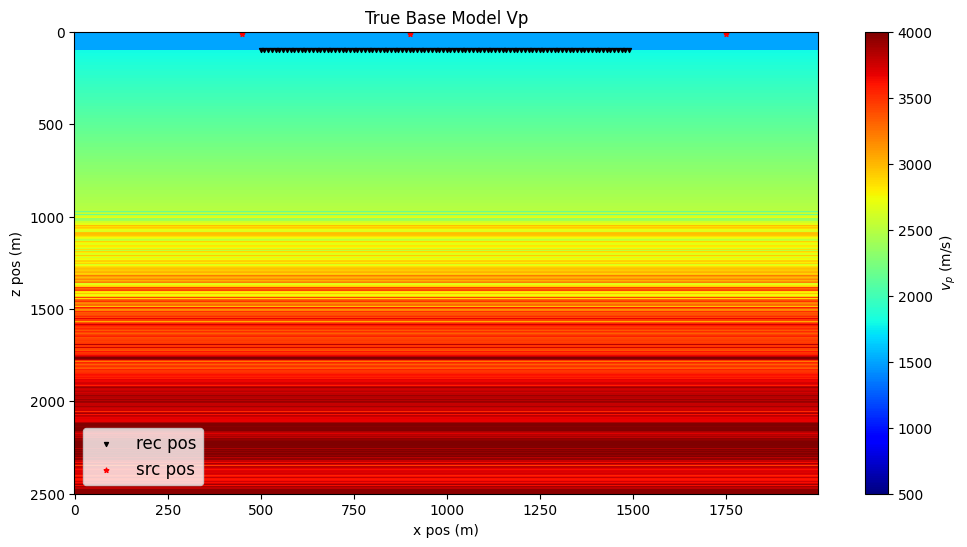

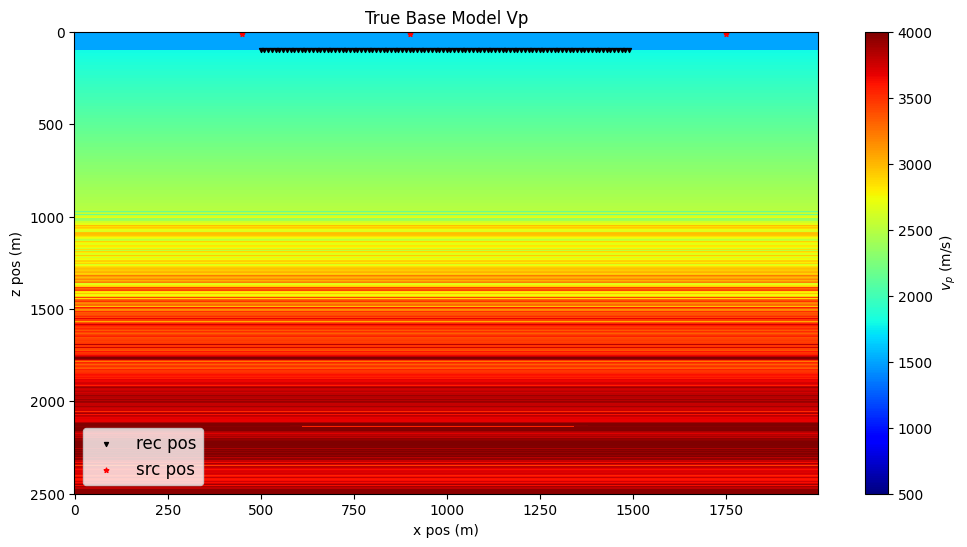

In [16]:
plotting.plot_model(vp2d_base_true,
                    title="True Base Model Vp",
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='jet',
                    cbar_label='$v_p$ (m/s)',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[500,4000])

plotting.plot_model(vp2d_moni_true,
                    title="True Base Model Vp",
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='jet',
                    cbar_label='$v_p$ (m/s)',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[500,4000])


# 4 Source Function + Make Data

In [17]:
### data_cal_base
acoustic_2d_obs_base = acoustic_isotropic.AcousticIsotropic2D(
    model=vp2d_base_true,
    model_sampling=model_sampling,
    model_padding=model_padding,
    wavelet=klauder,
    d_t=dt,
    src_locations=srcs,
    rec_locations=recs,
    model_origins=model_origins,
    subsampling=30,
    gpus=[0])

In [18]:
### data_cal_base
acoustic_2d_obs_moni = acoustic_isotropic.AcousticIsotropic2D(
    model=vp2d_moni_true,
    model_sampling=model_sampling,
    model_padding=model_padding,
    wavelet=klauder,
    d_t=dt,
    src_locations=srcs,
    rec_locations=recs,
    model_origins=model_origins,
    subsampling=30,
    gpus=[0])

In [19]:
### data_cal_base
acoustic_2d_cal_base = acoustic_isotropic.AcousticIsotropic2D(
    model=vp2d_base_init,
    model_sampling=model_sampling,
    model_padding=model_padding,
    wavelet=klauder,
    d_t=dt,
    src_locations=srcs,
    rec_locations=recs,
    model_origins=model_origins,
    subsampling=30,
    gpus=[0])

In [20]:
selected_rsdata_obs_base_p = acoustic_2d_obs_base.forward(vp2d_base_true)
selected_rsdata_obs_moni_p = acoustic_2d_obs_moni.forward(vp2d_moni_true)
selected_rsdata_cal_base_p = acoustic_2d_cal_base.forward(vp2d_base_init)

In [21]:
selected_sumdata_calb_dobs_p = selected_rsdata_cal_base_p \
                             + (selected_rsdata_obs_moni_p - selected_rsdata_obs_base_p)

# 5 FWI RUN

In [22]:
afwi4d_test = inversion.Fwi(acoustic_2d_cal_base,
                         selected_sumdata_calb_dobs_p,
                         vp2d_base_init,
                         num_iter=30,
                         solver_type='lbfgs',
                         stepper_type='parabolic',
                         iterations_per_save=5,
                         prefix='aFWI4d_flat_curved_p')

In [23]:
%%time
history = afwi4d_test.run()

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /home/test01/App/01_PySeis/xu/TASK6_PASS_Marine/numerical_modeling/wrk/restart_2025-10-30T01-12-06.269259/
##########################################################################################

iter = 00, obj = 7.33444e-04, resnorm = 3.83e-02, gradnorm = 2.51e-07, feval = 1, geval = 1
iter = 01, obj = 7.31897e-04, resnorm = 3.83e-02, gradnorm = 5.39e-07, feval = 4, geval = 2
iter = 02, obj = 7.30016e-04, resnorm = 3.82e-02, gradnorm = 5.98e-07, feval = 7, geval = 3
iter = 03, obj = 7.23311e-04, resnorm = 3.80e-02, gradnorm = 7.21e-07, feval = 10, geval = 4
iter = 04, obj = 7.15536e-04, resnorm = 3.78e-02, gradnorm = 8.88e-07, feval = 13, geval = 5
iter = 05, obj = 7.05275e-04, resnorm = 3.76e-02, gradnorm = 1.21e-06, feval = 16, geval = 6
iter = 06, obj = 6.95338e-04, resnorm = 3.73e-02, gradnorm = 1.05e-06, feval = 19, geval

#  6 Result

In [24]:
vp2d_moni_init.shape

(1000, 1251)

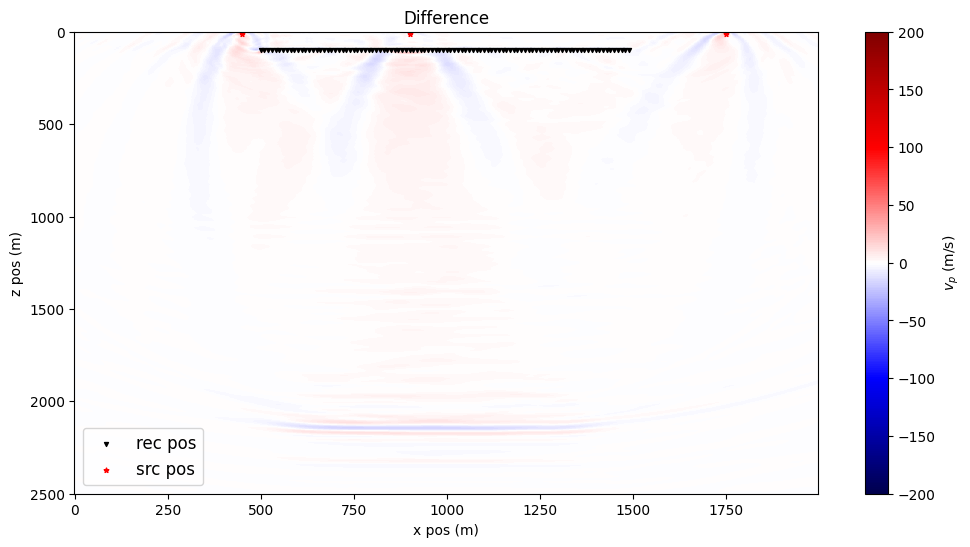

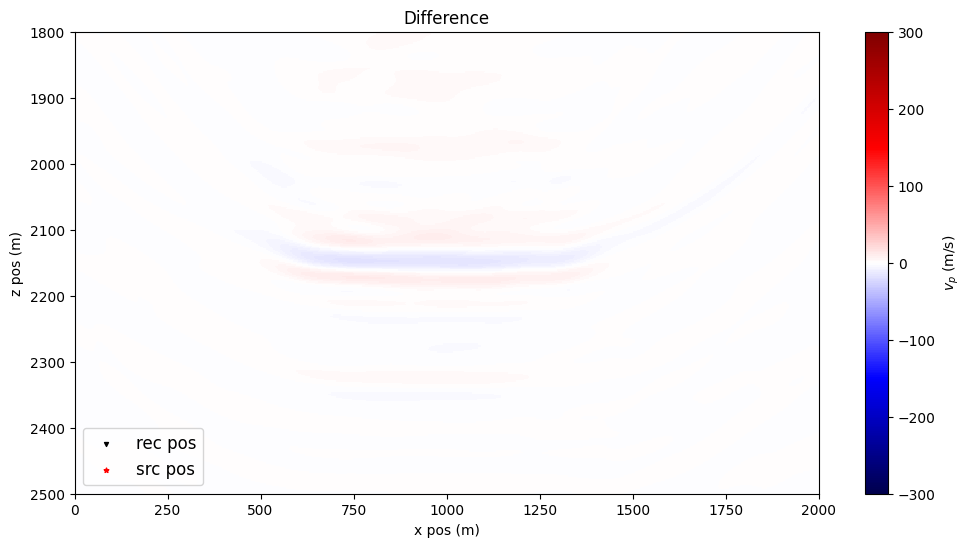

In [25]:
plotting.plot_model(history['inv_mod']-vp2d_base_init,
                    title='Difference',
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='seismic',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[-200,200],
                   )

plotting.plot_model(history['inv_mod']-vp2d_base_init,
                    title='Difference',
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='seismic',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[-300,300],
                    xlims=[0,2000],
                    ylims=[2500,1800]
                   )

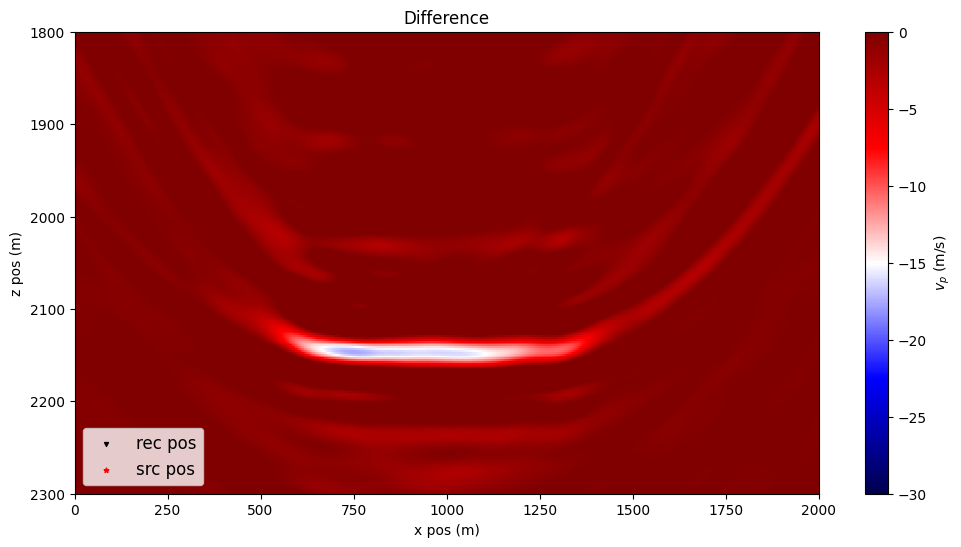

In [32]:
plotting.plot_model(history['inv_mod']-vp2d_base_init,
                    title='Difference',
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='seismic',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[-30,0],
                    xlims=[0,2000],
                    ylims=[2300,1800]
                   )


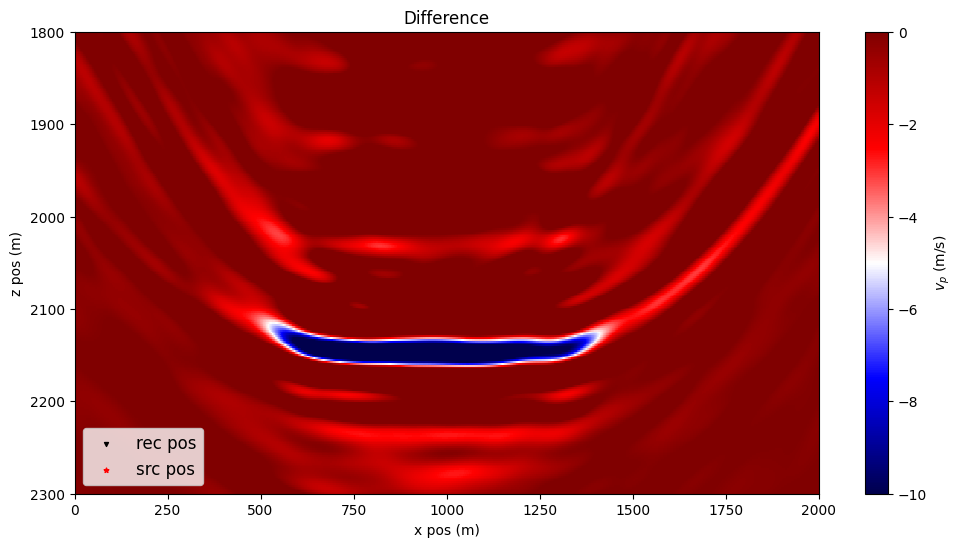

In [33]:
plotting.plot_model(history['inv_mod']-vp2d_base_init,
                    title='Difference',
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='seismic',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[-10,0],
                    xlims=[0,2000],
                    ylims=[2300,1800]
                   )


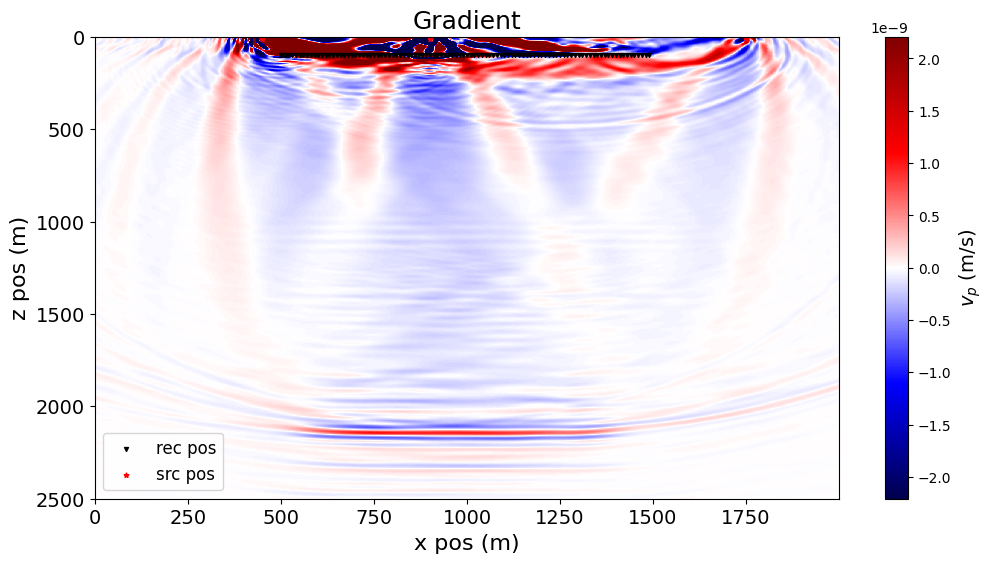

In [27]:
clip = np.percentile(np.abs(history['gradient'][0]), 99.99)

plotting.plot_model(history['gradient'][1], title='Gradient', cbar=True, sampling=model_sampling, origins=model_origins, cmap='seismic', src_locations=srcs, rec_locations=recs, figsize=(12,6), vlims=[-clip*0.5,clip*0.5], )


# --- Adjust label and title font sizes ---
ax = plt.gca()
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.set_title(ax.get_title(), fontsize=18)

# Optional: tick font size
ax.tick_params(axis='both', labelsize=14)

# Optional: colorbar label font size
cb = plt.gcf().axes[-1] if len(plt.gcf().axes) > 1 else None
if cb and cb.get_ylabel():
    cb.set_ylabel(cb.get_ylabel(), fontsize=14)

plt.show()

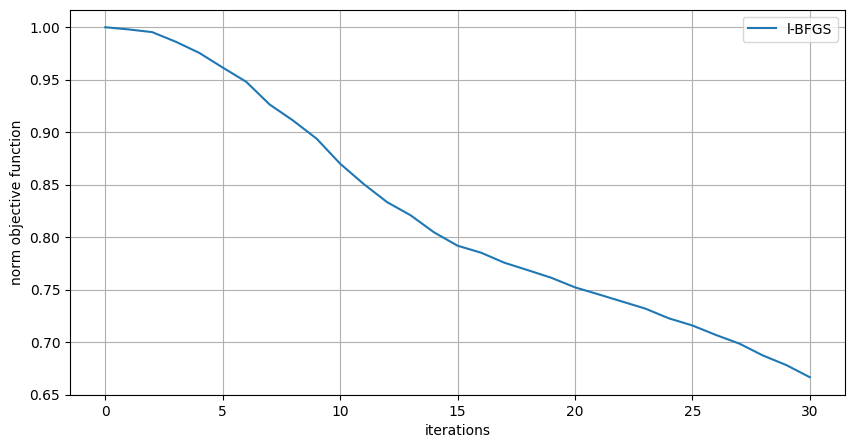

In [28]:
obj_func_original = history['obj']
fig, ax = plt.subplots(1,figsize=(10,5))
ax.plot(obj_func_original/obj_func_original.max(), label='l-BFGS')
_ = ax.set_xlabel('iterations')
_ = ax.set_ylabel('norm objective function')
ax.legend()
ax.grid()